In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
from rve_utils2 import CMAPSS
import random

### Get dataloaders:

In [3]:
#Sensor subsets from the original paper:

#sensors = ['s_3', 's_4', 's_7', 's_11', 's_12'] #FD001 FD003
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD004
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD002

# Dimensiomns should be powers of 2, due to upsampling and downsampling in UNet I guess
# UPDATE: desired output size could be passed to ConvTranspose2d:
# https://discuss.pytorch.org/t/the-output-size-of-convtranspose2d-differs-from-the-expected-output-size/1876
sensors = [f's_{i}' for i in range(1,17)]
print(f"Number of sensors used: {len(sensors)}")

input_size = len(sensors)
hidden_dim = 150
alpha=1
dataset_name = "FD004"
max_rul = 125
batch_size =256
window_size = 32

train_loader, test_loader, val_loader = CMAPSS(
    dataset_name=dataset_name, max_rul=max_rul, train_batch_size=batch_size, window_size=window_size, sensors=sensors, alpha=alpha
).get_dataloaders()

Number of sensors used: 16


### Visualizing window slices:

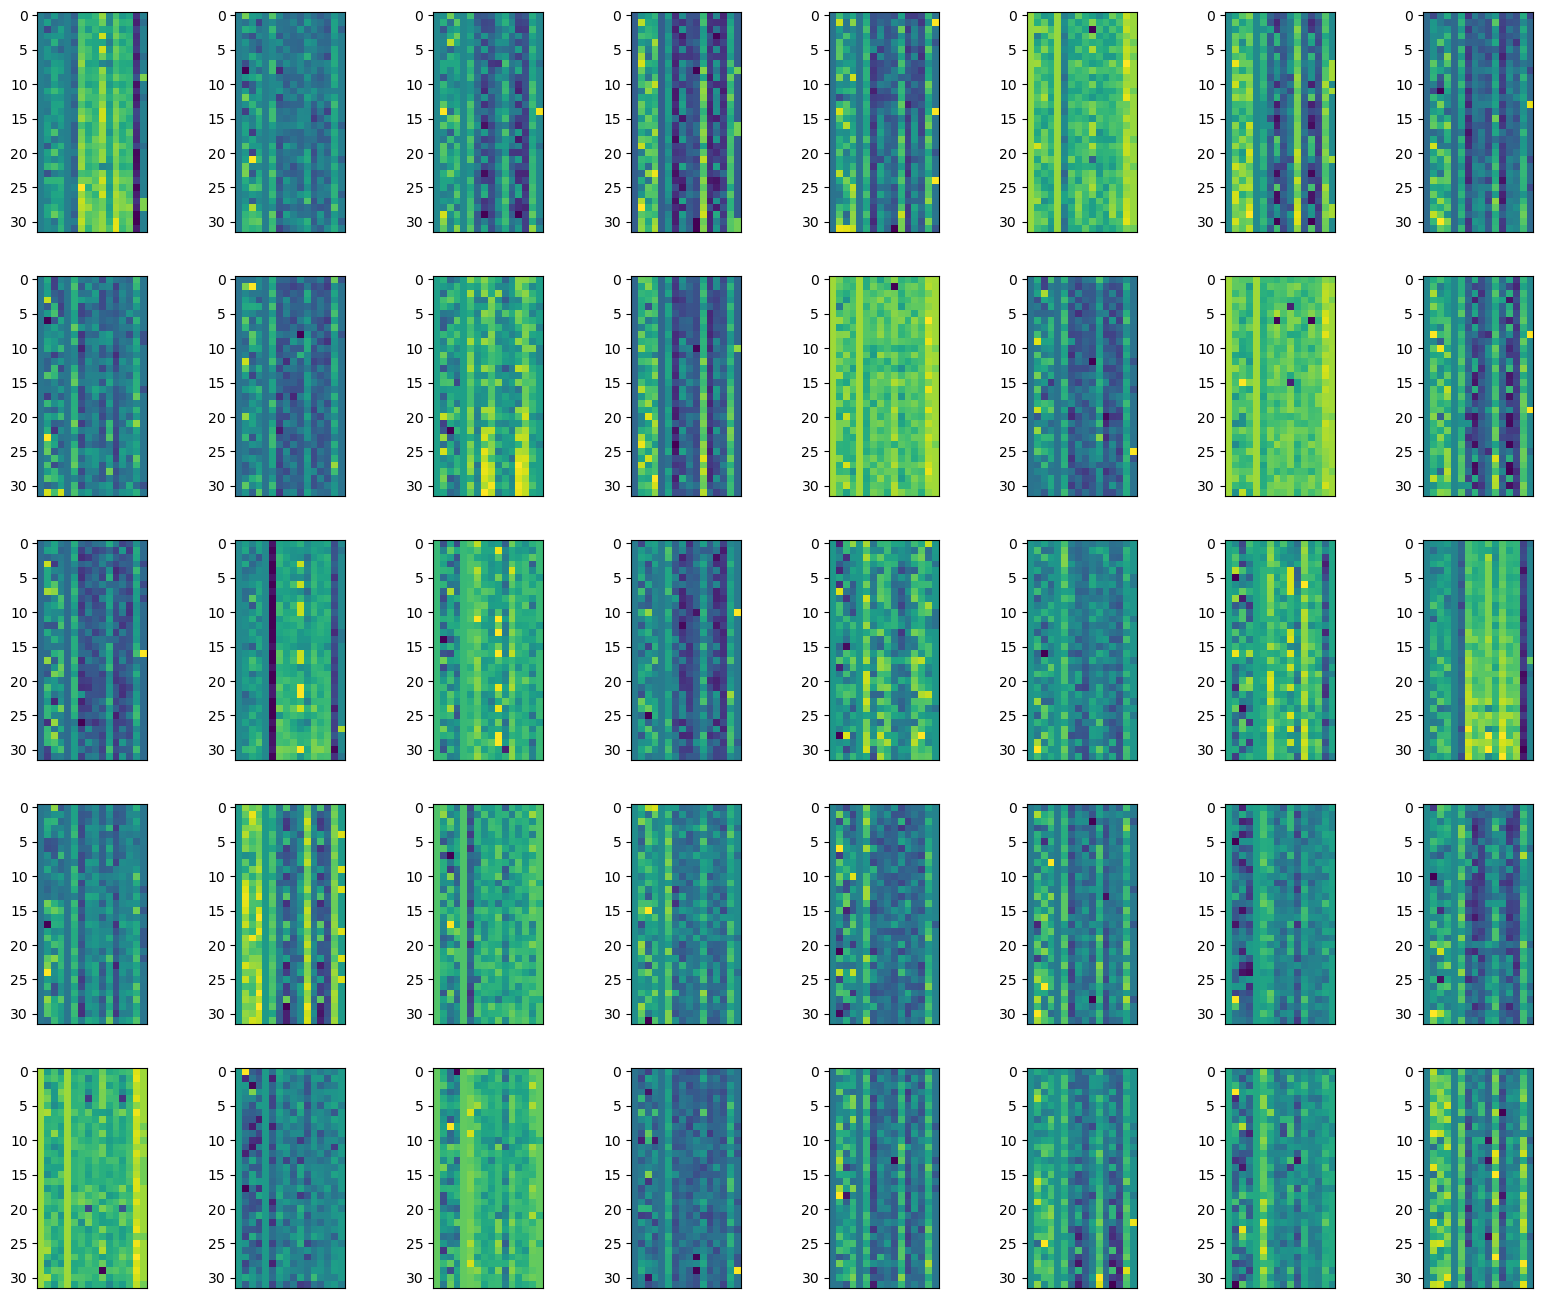

In [4]:
from random import randint

def show_images(data, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(20,20)) 
    data1 = [data[randint(0, len(data))] for _ in range(num_samples)]
    for i, img in enumerate(data1):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.xticks([], [])
        plt.imshow(img[0])
        
show_images(train_loader.dataset)

### Simple diffusion utils:

In [5]:
import torch.nn.functional as F

"""
Code taken from sources: 
https://www.youtube.com/watch?v=a4Yfz2FxXiY&ab_channel=DeepFindr
https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=Rj17psVw7Shg
"""

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]

    out = vals.gather(-1, t.cpu())

    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)

    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance

    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

### Vizualize forward noising:

First row: image with addition of noize.
Second row: noize added to image.

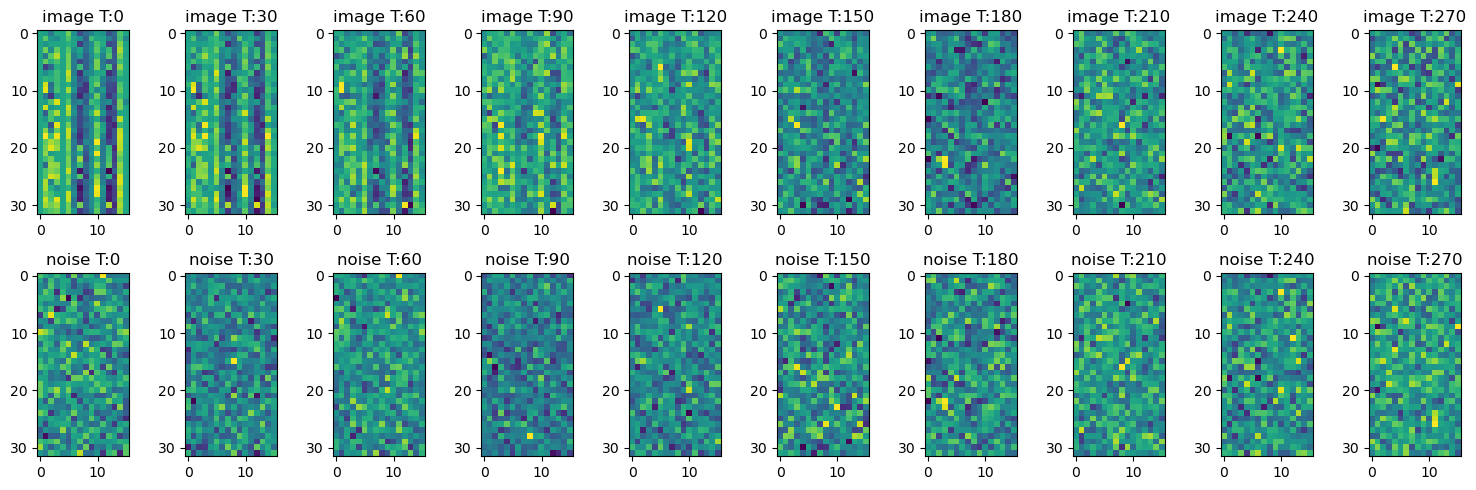

In [6]:
#Take random window frame from dataset:
image = train_loader.dataset[random.choice(range(len(train_loader.dataset)))][0]



num_images = 10
stepsize = int(T/num_images)

fig, axs = plt.subplots(2, num_images, figsize=(15,5))

# Apply noize according to the stepsize of T:
for i,idx in enumerate(range(0, T, stepsize)):
    t = torch.Tensor([idx]).type(torch.int64)
    image, noise = forward_diffusion_sample(image, t)
    axs[0][i].imshow(image)
    axs[0][i].set_title(f"image T:{idx}")
    axs[1][i].imshow(noise)
    axs[1][i].set_title(f"noise T:{idx}")
    #print(i, 1)
plt.tight_layout()

In [7]:
print(f" Shape of window frame: {image.shape}")

 Shape of window frame: torch.Size([32, 16])


### Unet model and positional embeddings:

In [8]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, ...)
            # see: https://discuss.pytorch.org/t/the-output-size-of-convtranspose2d-differs-from-the-expected-output-size/1876
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
           
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)



In [9]:
from torchinfo import summary

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62437601


In [10]:
summary(model, input_size=[( 1, 1, 32, 16), (1,)])

Layer (type:depth-idx)                        Output Shape              Param #
SimpleUnet                                    [1, 1, 32, 16]            --
├─Sequential: 1-1                             [1, 32]                   --
│    └─SinusoidalPositionEmbeddings: 2-1      [1, 32]                   --
│    └─Linear: 2-2                            [1, 32]                   1,056
│    └─ReLU: 2-3                              [1, 32]                   --
├─Conv2d: 1-2                                 [1, 64, 32, 16]           640
├─ModuleList: 1-3                             --                        --
│    └─Block: 2-4                             [1, 128, 16, 8]           --
│    │    └─Conv2d: 3-1                       [1, 128, 32, 16]          73,856
│    │    └─ReLU: 3-2                         [1, 128, 32, 16]          --
│    │    └─BatchNorm2d: 3-3                  [1, 128, 32, 16]          256
│    │    └─Linear: 3-4                       [1, 128]                  4,224
│    │  

In [11]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [12]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 


@torch.no_grad()
def sample_plot_image():
    """
    Plots one sample image as it is reconstructed from generated noise.
    First image is generated as random noise, then for each T the reconstruction process is performed.
    Plots 10 timesteps of reconstruction process.
    """

    img = torch.randn((1, 1, 32, 16), device=device)
    plt.figure(figsize=(15,15))
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.imshow(img.detach().cpu()[0][0])
            plt.title(f"T={i}")
            plt.axis('off')
    plt.show()   

#### Training Loop:

Epoch 0 | step 162 Loss: 0.35685989633398985 


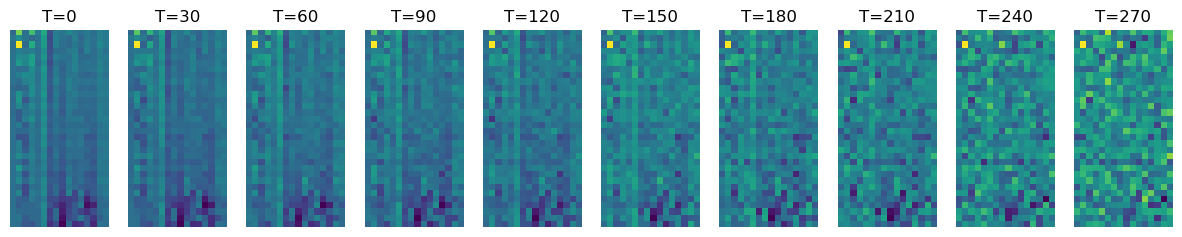

Epoch 1 | step 162 Loss: 0.30449161437652544 
Epoch 2 | step 162 Loss: 0.2983136231307472 


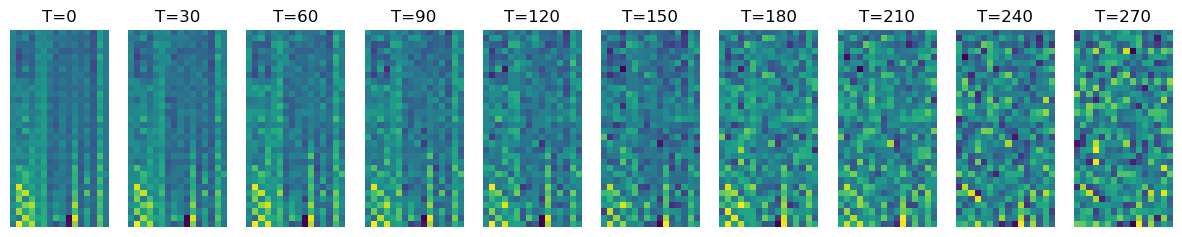

Epoch 3 | step 162 Loss: 0.295401624889846 
Epoch 4 | step 162 Loss: 0.2924135847911928 


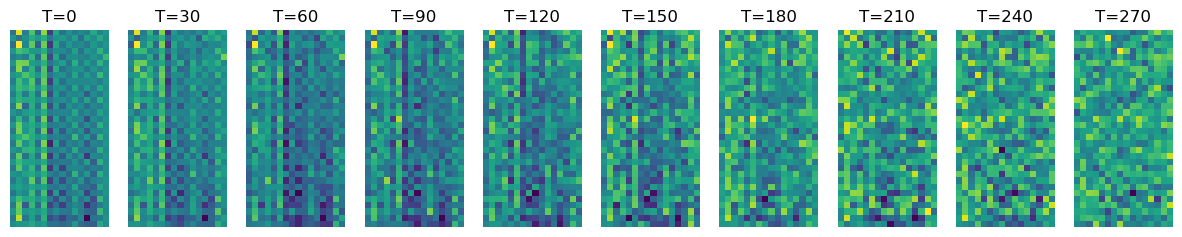

Epoch 5 | step 162 Loss: 0.29220945363470807 


In [13]:
from torch.optim import Adam

model = SimpleUnet()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 6 # Try more!

for epoch in range(epochs):
    epoch_loss = 0
    for step, batch in enumerate(train_loader):
        batch_size = batch[0].shape[0]
        #print("batch_size", batch_size)
        optimizer.zero_grad()

        t = torch.randint(0, T, (batch_size,), device=device).long()
        loss = get_loss(model, batch[0].unsqueeze(1), t)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*batch_size

    print(f"Epoch {epoch} | step {step:03d} Loss: {epoch_loss/len(train_loader.dataset)} ")
    if epoch % 2 == 0:
        sample_plot_image()

### Second Realization of Diffusion (more complicated with Attention)

The code was taken from this source: https://aman.ai/primers/ai/diffusion-models/  

Seems to be similar to Annotated Diffussion: https://huggingface.co/blog/annotated-diffusion

In [14]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

In [15]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [16]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim


    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [17]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()


    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()


    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()


    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [18]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)


    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))


    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [19]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)


    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [20]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [21]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

Epoch 0 | step 162 Loss: 0.5039783217201103 


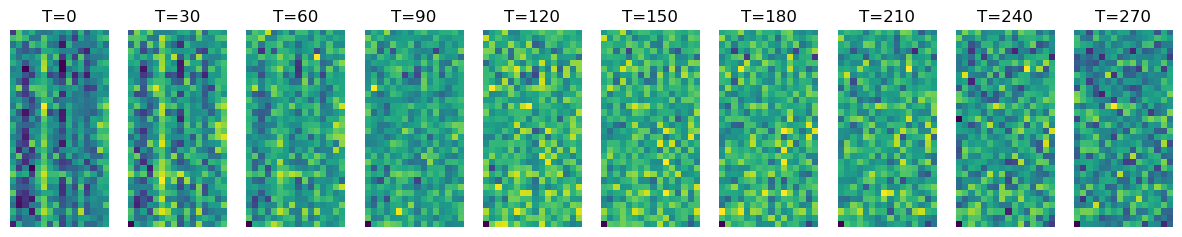

Epoch 1 | step 162 Loss: 0.3219430185402636 
Epoch 2 | step 162 Loss: 0.30591249507229334 


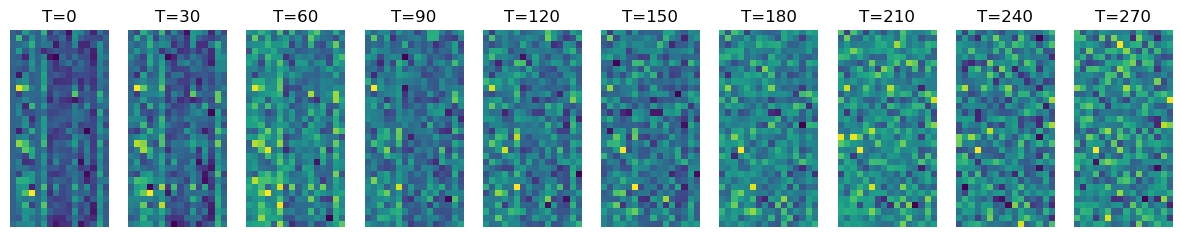

Epoch 3 | step 162 Loss: 0.3004296351288293 
Epoch 4 | step 162 Loss: 0.29418402009491246 


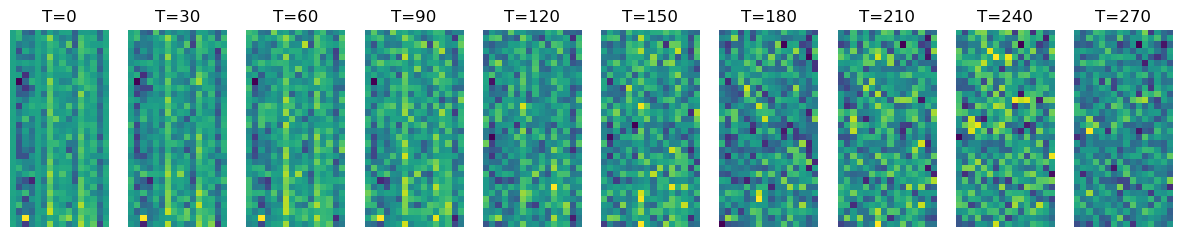

Epoch 5 | step 162 Loss: 0.291534143205423 


In [22]:
model = Unet(
    dim=32,
    channels=1,
    dim_mults=(1, 2, 4,)
)


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 6 # Try more!

for epoch in range(epochs):
    epoch_loss = 0
    for step, batch in enumerate(train_loader):
        batch_size = batch[0].shape[0]
        #print("batch_size", batch_size)
        optimizer.zero_grad()

        t = torch.randint(0, T, (batch_size,), device=device).long()
    
        loss = get_loss(model, batch[0].unsqueeze(1), t)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*batch_size

    print(f"Epoch {epoch} | step {step:03d} Loss: {epoch_loss/len(train_loader.dataset)} ")
    if epoch % 2 == 0:
        sample_plot_image()